In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import percentileofscore
from datetime import timedelta
import matplotlib.ticker as ticker

## огляд дати 

In [200]:
df = pd.read_csv('testTask2.csv')
df.head()

,moderator,id_request,request_time,start_time,finish_time,team
0,165,159660,2020-09-24 7:01:16,2020-10-01 16:00:31,2020-10-01 16:02:02,retail
1,178,160116,2020-09-24 22:32:15,2020-10-01 13:21:42,2020-10-01 13:21:43,retail
2,187,160178,2020-09-25 2:58:13,2020-10-02 11:37:16,2020-10-02 11:41:56,wholesale
3,178,160306,2020-09-25 9:44:12,2020-10-02 7:23:09,2020-10-02 7:25:33,retail
4,178,163042,2020-09-30 15:56:08,2020-10-02 7:37:33,2020-10-02 7:47:57,retail


Датасет має 35617 тисяч записів, що вселяє надію про те, що висновки будуть обʼєктивними за умови правильно підходу до аналізу =) 

In [201]:
df.shape

(35617, 6)

Кожне завдання старанний агент служби підтримки може виконувати до 5 хвилин з момента взяття в роботу.
З боку менеджменту є очікування, що в рамках кожного дня середній час від виникнення нового запиту користувача до відповіді має бути 15 хвилин. Також погано, якщо користувачі сервісу чекають на відповідь довше 45 хвилин.

In [202]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['finish_time'] = pd.to_datetime(df['finish_time'])
df['request_time'] = pd.to_datetime(df['request_time'])

Пояснення до колонок, які я додала нижче

**З боку менеджменту є очікування, що в рамках кожного дня середній час від виникнення нового запиту користувача до відповіді має бути 15 хвилин**

before_1_resp_min - чаc(хв) з моменту запиту користувача до першої відповіді (очікуємо, що цей час має бути в середньому 15 хвилин, погано, якщо 45)

solve_prblm_min - чаc(хв) на виконання запиту з моменту взяття його в роботу до остаточної відповіді (має бути до 5 хв)

total_requests_by_mod - загальна кількість запитів, виконаних модератором  за увесь час роботи

In [203]:
df['before_1_resp_min'] = round((df['start_time'] - df['request_time']).dt.total_seconds()/60, 3)
df['solve_prblm_min'] = round((df['finish_time'] - df['start_time']).dt.total_seconds()/60, 3)
df["total_requests_by_mod"] = df.groupby("moderator")["id_request"].transform("count")
df.to_csv("df_with additional_inf.csv")
df.head()

,moderator,id_request,request_time,start_time,finish_time,team,before_1_resp_min,solve_prblm_min,total_requests_by_mod
0,165,159660,2020-09-24 07:01:16,2020-10-01 16:00:31,2020-10-01 16:02:02,retail,10619.250,1.517,698
1,178,160116,2020-09-24 22:32:15,2020-10-01 13:21:42,2020-10-01 13:21:43,retail,9529.450,0.017,630
2,187,160178,2020-09-25 02:58:13,2020-10-02 11:37:16,2020-10-02 11:41:56,wholesale,10599.050,4.667,1193
3,178,160306,2020-09-25 09:44:12,2020-10-02 07:23:09,2020-10-02 07:25:33,retail,9938.950,2.400,630
4,178,163042,2020-09-30 15:56:08,2020-10-02 07:37:33,2020-10-02 07:47:57,retail,2381.417,10.400,630


Дивлюсь протягом якого часу я маю дані (день, тиждень, місяць, рік)

Дані маємо приблизно за 3 місяці

In [204]:
data_period = max(df['finish_time']) -  min(df['request_time'])
data_period


Timedelta('98 days 15:51:00')

Візуалізую час очікування на першу відповідь протягом цих трьох місяців

Видно, що є певний період, де користувачі не отримували відповіді не просто годинами, а тижнями

Причому ця ситупція спостерігається в обох командах

Причини такої затримки можуть бути різні: катастрофи ([ось наприклад знайшла інформація про повінь y Вʼєтнамі 20 жовтня 2020 року](https://www.bbc.com/news/world-asia-54615756)), технічні неполадки на сервері, зміна policy



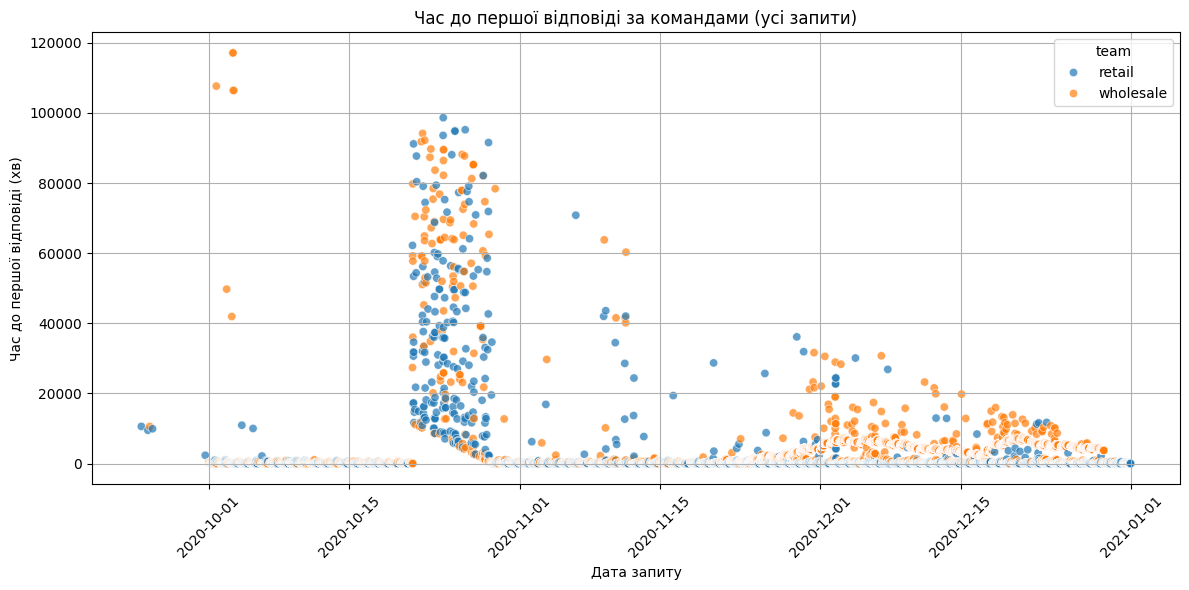

In [205]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='request_time', y='before_1_resp_min', hue='team', alpha=0.7)
plt.xlabel('Дата запиту')
plt.ylabel('Час до першої відповіді (хв)')
plt.title('Час до першої відповіді за командами (усі запити)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Я видаляю ці данні (в проміжку з 2020-10-21 і 2020-10-29 включно), бо припускаю, що в цей час модератори не відповідали на запити через непереборну силу

Також ви можете побачити побачити одиночні запити, у яких дуже великий час очікуівання (>10000 хв), тому я теж такі дані видаляю

Цих даних в результаті видалиться не так багато в відносно загальної кількості записів, які є в датасеті (видалиться близько 700(приблизно 2% даних))

In [206]:
df = df[~(
    (df['request_time'].dt.month == 10) &(df['request_time'].dt.day >= 21) & (df['request_time'].dt.day <= 29) 
)]

df.shape
df = df[df['before_1_resp_min'] < 7000]
df.shape

(34466, 9)

На графіку нижче можна побачити поступове зростання часу очікування першої відповіді у грудні саме у wholesale команди, але це я вже не видалятиму, а розділю дані по командам і подосліджую.

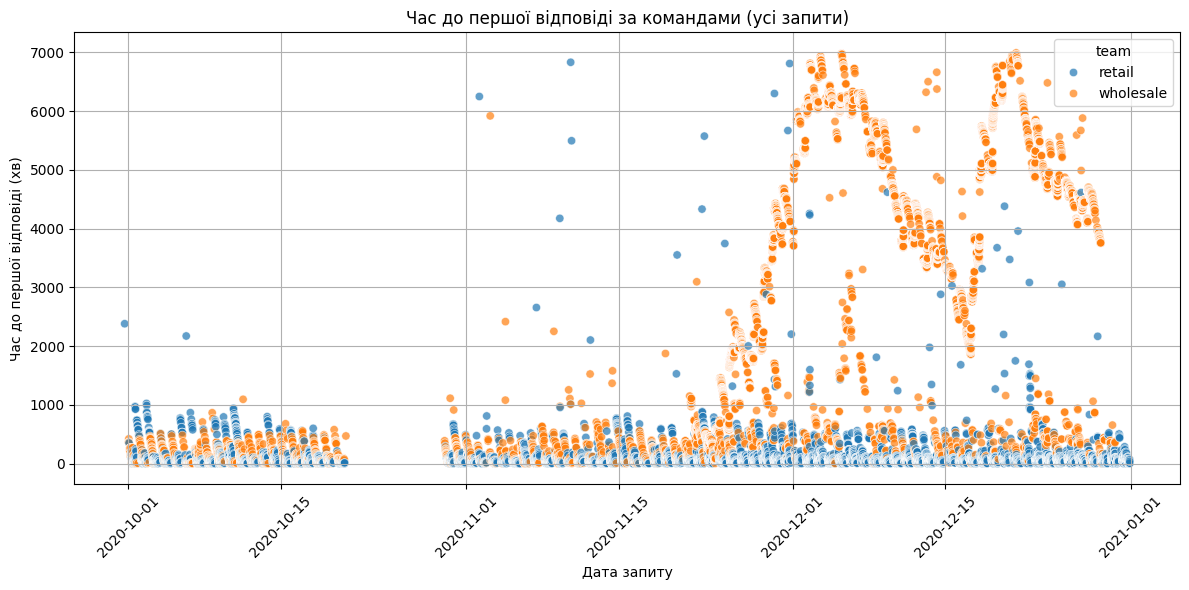

In [207]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='request_time', y='before_1_resp_min', hue='team', alpha=0.7)
plt.xlabel('Дата запиту')
plt.ylabel('Час до першої відповіді (хв)')
plt.title('Час до першої відповіді за командами (усі запити)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Нижче я розділяю дані окремо на retail та wholesale

In [208]:
retail_df = df[df['team'] == 'retail']
wholesale_df = df[df['team'] == 'wholesale']
retail_df.shape, wholesale_df.shape

((13701, 9), (20765, 9))

Нижче я ще трошки прибираю даних з retail, щоб мати більш ясну картину. Так як даних достатньо, то загальну картину вони не змінять, а навпаки допоможуть зробити висновики.

In [209]:
retail_df = retail_df[retail_df['before_1_resp_min'] < 780]
retail_df["total_requests_by_mod"] = retail_df.groupby("moderator")["id_request"].transform("count")
retail_df.shape

(13600, 9)

In [210]:
# df["total_requests_by_mod"] = df.groupby("moderator")["id_request"].transform("count")
# df.to_csv("df_with additional_inf.csv")
# wholesale_df = wholesale_df[wholesale_df['before_1_resp_min'] < 5000]
# wholesale_df.shape

Візуалізую, час очікування на першу відповідь у команди retail та команди wholesale

В обох командах видно великий правий хвіст, що означає, що частина запитів виконується більше, ніж 15 хвилин.

Причому у команді wholesale багато запитів мають значно довший час очікування, ніж навіть 45 хвилин.

Далі визначаю який персентиль, що відповідає значенню 15 хвилин (якраз те, що очікується менеджментом) в кожній з команд.

У retail команди це значення 17%, що означає, що тільки 17% запитів отримують першу відповідь протягом 15 хвилин, а всі інші 83% запитів отримують першу відповідь більш, ніж за 15 хвилин.

У wholesale команди це значення 2%, що означає, що тільки 2% запитів отримують першу відповідь протягом 15 хвилин, а всі інші 98% запитів отримують першу відповідь більш, ніж за 15 хвилин.




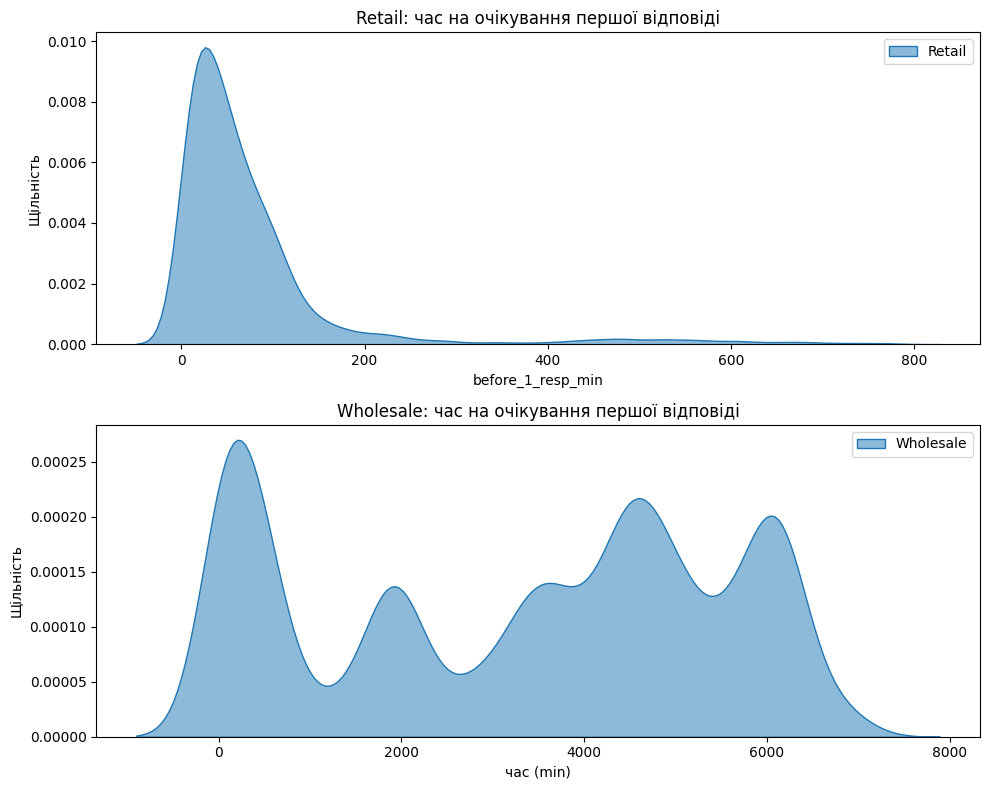

In [211]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
sns.kdeplot( data=retail_df, x='before_1_resp_min', label='Retail',
    fill=True,
    alpha=0.5,
    ax=axes[0])
axes[0].set_title('Retail: час на очікування першої відповіді')
axes[0].set_ylabel('Щільність')
axes[0].legend()
sns.kdeplot( data=wholesale_df, x='before_1_resp_min', label='Wholesale',
    fill=True,
    alpha=0.5,
    ax=axes[1])
axes[1].set_title('Wholesale: час на очікування першої відповіді')
axes[1].set_xlabel('час (min)')
axes[1].set_ylabel('Щільність')
axes[1].legend()

plt.tight_layout()
plt.show()


In [212]:
percentile_retail = percentileofscore(retail_df['before_1_resp_min'], 15)
percentile_wholesale = percentileofscore(wholesale_df['before_1_resp_min'], 15)
print("Відсоток користувачів, що очікують на першу відповідь менше ніж 15 хв")
print(f"У retail команди {round(percentile_retail, 2)}\nУ wholesale команди {round(percentile_wholesale, 2)}")

Відсоток користувачів, що очікують на першу відповідь менше ніж 15 хв
У retail команди 17.28
У wholesale команди 2.42


In [213]:
percentile_retail = percentileofscore(retail_df['before_1_resp_min'], 45)
percentile_wholesale = percentileofscore(wholesale_df['before_1_resp_min'], 45)
print("Відсоток користувачів, що очікують на першу відповідь більше, ніж 45 хв")
print(f"У retail команди {round(100 - percentile_retail, 2)}\nУ wholesale команди {round(100 - percentile_wholesale, 2)}")

Відсоток користувачів, що очікують на першу відповідь більше, ніж 45 хв
У retail команди 51.74
У wholesale команди 94.74


Візуалізую, час на вирішення проблеми (різниця часу між першою і фінальною відповіддю фахівця) у команди retail та команди wholesale

<!-- В обох командах видно великий правий хвіст, що означає, що частина запитів виконується більше, ніж 15 хвилин -->

Далі визначаю який персентиль, що відповідає значенню 5 хвилин.

У retail команди це значення 92%, що означає, що 92% запитів отримують фінальну відповідь менше, ніж за 5 хвилин після першої відповіді, а всі інші 8% запитів отримують фінальну відповідь більше, ніж за 5 хвилин.

У wholesale команди це значення 87%, що означає, що 87% запитів отримують фінальну відповідь менше, ніж за 5 хвилин після першої відповіді, а всі інші 13% запитів отримують фінальну відповідь більше, ніж за 5 хвилин.


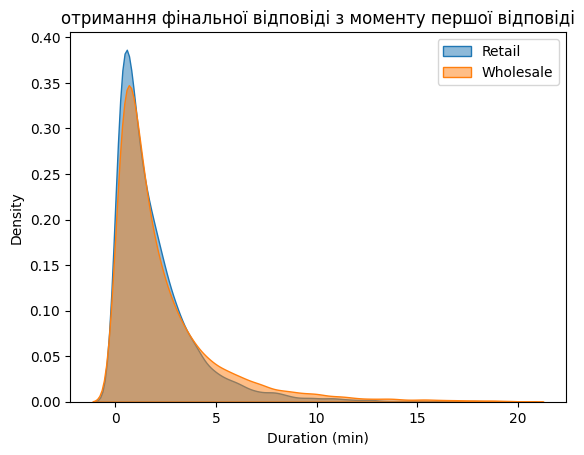

In [214]:
sns.kdeplot(data=retail_df, x='solve_prblm_min', label='Retail', fill=True, alpha=0.5)
sns.kdeplot(data=wholesale_df, x='solve_prblm_min', label='Wholesale', fill=True, alpha=0.5)

plt.xlabel('Duration (min)')
plt.title('отримання фінальної відповіді з моменту першої відповіді')
plt.legend()
plt.show()

In [215]:
percentile_retail_f = percentileofscore(retail_df['solve_prblm_min'], 5)
percentile_wholesale_f = percentileofscore(wholesale_df['solve_prblm_min'],5)

print("Відсоток користувачів, що отримують фінальну відповідь менше за 5 хв")
print(f"У retail команди {round(percentile_retail_f, 2)}\nУ wholesale команди {round(percentile_wholesale_f, 2)}")

Відсоток користувачів, що отримують фінальну відповідь менше за 5 хв
У retail команди 92.26
У wholesale команди 87.3


### Висновок
Час очікування на першу відповідь не відповідає очікуванням менеджменту, є величезні затримки в обох команд.

Час обробки завдання (різниця в часі між першою відповіддю і фінальною) відповідає очікуванням менеджменту.

Визначаю кількість запитів щомісяця, яка в загальному надійшла до обох команд

In [216]:
monthly_counts = df.groupby(df["request_time"].dt.to_period("M"))["id_request"].count()
monthly_counts

request_time
2020-09        1
2020-10     4797
2020-11    10661
2020-12    19007
Freq: M, Name: id_request, dtype: int64

In [217]:
months = {"SEP": 9, "OCT": 10, "NOV": 11, "DEC": 12}
for month, num in months.items():
    month_requests = df[df["request_time"].dt.month == num]
    requests_per_day_month = month_requests.groupby(df["request_time"].dt.date)["id_request"].count()
    max_day = requests_per_day_month.idxmax()
    max_count = requests_per_day_month.max()
    print(f"Day in {month} 2020 with the most requests: {max_day} ({max_count} requests)")


Day in SEP 2020 with the most requests: 2020-09-30 (1 requests)
Day in OCT 2020 with the most requests: 2020-10-09 (349 requests)
Day in NOV 2020 with the most requests: 2020-11-25 (1226 requests)
Day in DEC 2020 with the most requests: 2020-12-11 (948 requests)


## Досліджую графік роботи обох команд

В коді нижче я знаходжу суманрну кількість запитів, отриманих в ту чи іншу годину доби і відповідно порівнюю це з кількістю модераторів протягом цього часу на роботі.

In [218]:
retail_df = retail_df.copy()
retail_df['hour_of_day'] = retail_df['request_time'].dt.hour
hourly_distribution = retail_df.groupby('hour_of_day').size().reset_index(name='count')
hourly_distribution = hourly_distribution.sort_values(by='hour_of_day')


In [219]:
hourly_records_retail = []

for i, row in retail_df.iterrows():
    start = row['start_time']
    end = row['finish_time']
    current =start

    while current < end:
        hourly_records_retail.append({
            'hour_of_day': current.hour,
            'moderator': row['moderator']})
        current += timedelta(hours=1)

hourly_df = pd.DataFrame(hourly_records_retail)

moderator_activity = hourly_df.groupby('hour_of_day')['moderator'].nunique().reset_index(name='num_moderators')
moderator_activity = moderator_activity.sort_values(by='hour_of_day')


На графіку нижче для обох команд видно, що є періоди, де запити є, а модераторів на їх обробку немає.

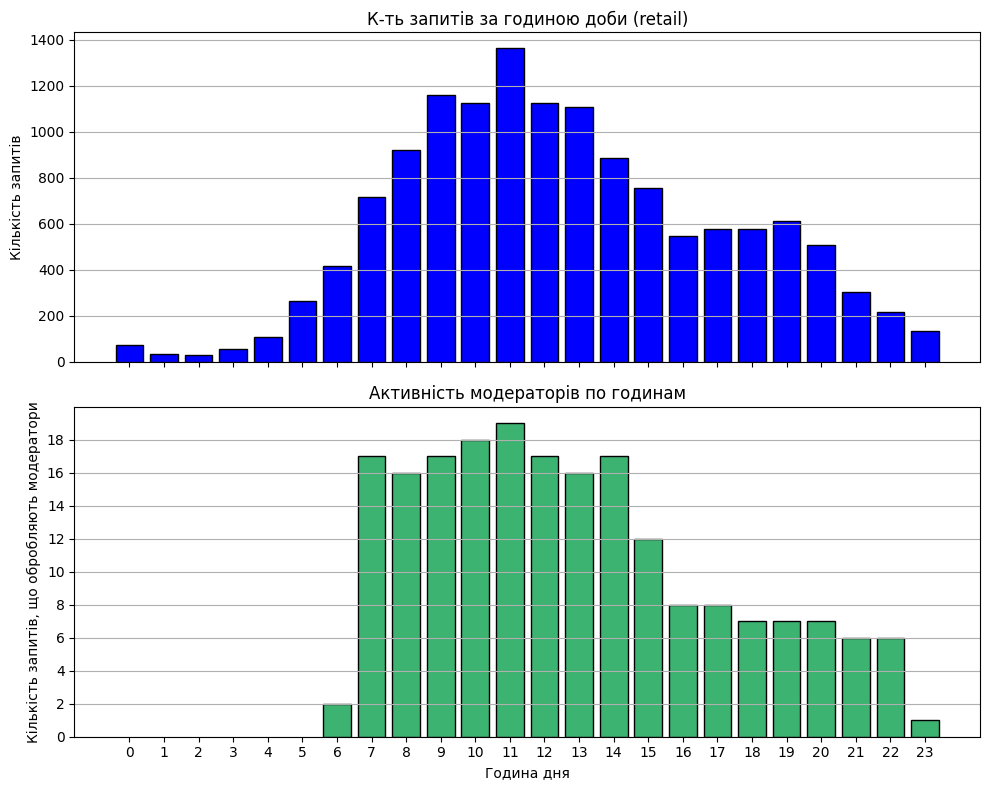

In [220]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

axes[0].bar(hourly_distribution['hour_of_day'], hourly_distribution['count'], color='blue', edgecolor='black')
axes[0].set_title("К-ть запитів за годиною доби (retail)")
axes[0].set_ylabel("Кількість запитів")
axes[0].grid(axis='y')

axes[1].bar(moderator_activity['hour_of_day'], moderator_activity['num_moderators'], color='mediumseagreen', edgecolor='black')
axes[1].set_title("Активність модераторів по годинам")
axes[1].set_xlabel("Година дня")
axes[1].set_ylabel("Кількість запитів, що обробляють модератори")
axes[1].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
axes[1].grid(axis='y')

plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

In [221]:
wholesale_df = wholesale_df.copy()
# wholesale_df = wholesale_df[wholesale_df['before_1_resp_min'] < 1000]
wholesale_df['hour_of_day'] = wholesale_df['request_time'].dt.hour
hourly_distribution = wholesale_df.groupby('hour_of_day').size().reset_index(name='count')
hourly_distribution = hourly_distribution.sort_values(by='hour_of_day')

In [222]:
hourly_records_wholesale = []

for _, row in wholesale_df.iterrows():
    start = row['start_time']
    end = row['finish_time']
    current = start

    while current < end:
        hourly_records_wholesale.append({
            'hour_of_day': current.hour,
            'moderator': row['moderator']
        })
        current += timedelta(hours=1)

hourly_df = pd.DataFrame(hourly_records_wholesale)

moderator_activity = hourly_df.groupby('hour_of_day')['moderator'].nunique().reset_index(name='num_moderators')
moderator_activity = moderator_activity.sort_values(by='hour_of_day')


На графіку нижче для wholesale яскраво видно, що є дуже багато запитів в період з 12 a.m до 6 a.m а модераторів на їх обробку немає.

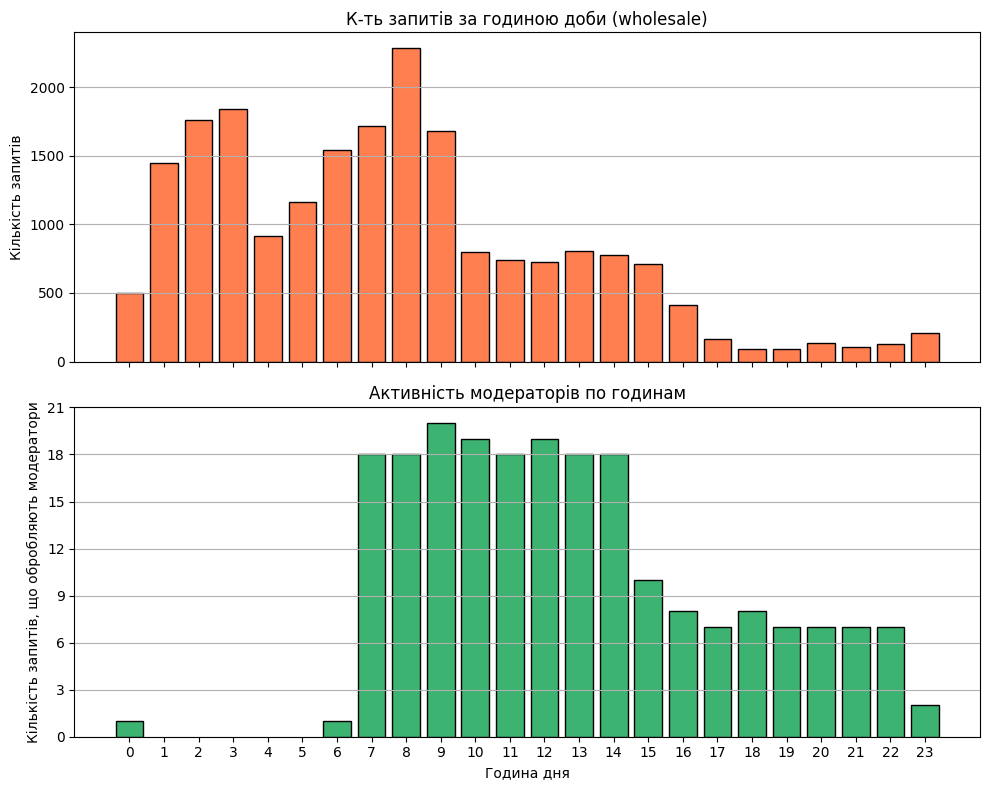

In [223]:

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

axes[0].bar(hourly_distribution['hour_of_day'], hourly_distribution['count'], color='coral', edgecolor='black')
axes[0].set_title("К-ть запитів за годиною доби (wholesale)")
axes[0].set_ylabel("Кількість запитів")
axes[0].grid(axis='y')

axes[1].bar(moderator_activity['hour_of_day'], moderator_activity['num_moderators'], color='mediumseagreen', edgecolor='black')
axes[1].set_title("Активність модераторів по годинам")
axes[1].set_xlabel("Година дня")
axes[1].set_ylabel("Кількість запитів, що обробляють модератори")
axes[1].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
axes[1].grid(axis='y')

plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

## Висновок 
В період з 0 a.m. до 6 p.m. є запити користувачів, але немає модераторів, щоб їх обробляти

Рекомендація: потрібно змінити графік роботи модераторів

## На яких агентів варто звернути увагу задля підвищення якості обслуговування?


перевіряю, чи є модератори, що працюють у двох командах

немає =)

In [224]:
mod_in_two_teams = []
for mod in retail_df["moderator"].unique():
    if mod in wholesale_df["moderator"].unique():
        mod_in_two_teams.append(mod)
mod_in_two_teams

[]

Визначаю медіанний час очікування у модераторів з retail та wholesale

Тут я не враховуватиму модераторів, які обробили менше, ніж 60 запитів, адже інші порівняно з ними обробили набагато більше запитів.

In [225]:
retail_moderators = retail_df.groupby("moderator")[["before_1_resp_min", "total_requests_by_mod"]].median().sort_values(by=["before_1_resp_min", "total_requests_by_mod"], ascending=False)
retail_moderators

,before_1_resp_min,total_requests_by_mod
moderator,,
133,439.0000,2.0
150,114.6500,16.0
173,73.7670,589.0
165,62.2670,659.0
167,61.3170,495.0
141,60.4000,695.0
121,54.2830,783.0
136,52.8670,719.0
164,52.3830,623.0


Тут я все таки вирішила прибрати ті аномальні значення у wholesale команди. Так, я розумію, що просто прибрала 3/4 даних і це не дуже ок. Але поки не розумію причини цих аномальних значень, разом з тим не можу адекватно аналізувати результат. Я вважаю, що ці аномалії треба ще  прокомунікувати.

In [226]:
wholesale_df = wholesale_df[wholesale_df['before_1_resp_min'] < 1000]
wholesale_df.shape

(5279, 10)

In [227]:
wholesale_moderators = wholesale_df.groupby("moderator")[["before_1_resp_min", "total_requests_by_mod"]].median().sort_values(by=["before_1_resp_min", "total_requests_by_mod"], ascending=False)
wholesale_moderators

,before_1_resp_min,total_requests_by_mod
moderator,,
185,621.7670,25.0
188,421.0835,3746.0
102,356.0500,1321.0
180,354.2165,1349.0
170,320.1920,1686.0
153,295.2830,838.0
123,290.5835,1452.0
122,259.4085,767.0
146,217.7830,909.0


прибираю тих модераторів, які є викидами з точки зору виконаних запитів за увесь час

я вважаю, що якщо запитів дуже мало, то можливо це взагалі стажери, які тренувались 

можна було би визначати викди і видаляти за користуючись таким правилом, але value < Q1 - 1.5 × IQR

value > Q3 + 1.5 × IQR
, але тоді воно видаляє людину, яка зробила 477 запитів, а я би не видаляла її

In [228]:
retail_df = retail_df[retail_df["total_requests_by_mod"] > 61]
retail_moderators = retail_df.groupby("moderator")[["before_1_resp_min", "total_requests_by_mod"]].median().sort_values(by=["before_1_resp_min", "total_requests_by_mod"], ascending=False)
retail_moderators

,before_1_resp_min,total_requests_by_mod
moderator,,
173,73.7670,589.0
165,62.2670,659.0
167,61.3170,495.0
141,60.4000,695.0
121,54.2830,783.0
136,52.8670,719.0
164,52.3830,623.0
186,47.5415,1316.0
176,47.1330,787.0


In [229]:
wholesale_df = wholesale_df[wholesale_df["total_requests_by_mod"] > 61]
wholesale_moderators = wholesale_df.groupby("moderator")[["before_1_resp_min", "total_requests_by_mod"]].median().sort_values(by=["before_1_resp_min", "total_requests_by_mod"], ascending=False)
wholesale_moderators

,before_1_resp_min,total_requests_by_mod
moderator,,
188,421.0835,3746.0
102,356.0500,1321.0
180,354.2165,1349.0
170,320.1920,1686.0
153,295.2830,838.0
123,290.5835,1452.0
122,259.4085,767.0
146,217.7830,909.0
125,197.7000,1146.0


In [230]:
retail_df['date'] = retail_df['start_time'].dt.date 
working_days_r = retail_df.groupby('moderator')['date'].nunique().reset_index(name='num_working_days')

In [231]:
total_requests = retail_df[['moderator', 'total_requests_by_mod']].drop_duplicates()
mod_stats = pd.merge(working_days_r, total_requests, on='moderator')
mod_stats['avg_requests_per_day'] = (mod_stats['total_requests_by_mod'] // mod_stats['num_working_days'])
mod_stats = mod_stats.sort_values(by='avg_requests_per_day', ascending=False)
mod_stats[['moderator', 'num_working_days', 'total_requests_by_mod', 'avg_requests_per_day']]

,moderator,num_working_days,total_requests_by_mod,avg_requests_per_day
17,186,27,1316,48
2,117,27,1229,45
7,148,25,725,29
0,109,28,803,28
13,172,34,927,27
4,135,31,835,26
11,165,25,659,26
15,176,33,787,23
3,121,35,783,22
5,136,35,719,20


In [232]:
wholesale_df['date'] = wholesale_df['start_time'].dt.date 
working_days_w = wholesale_df.groupby('moderator')['date'].nunique().reset_index(name='num_working_days')


In [233]:
total_requests = wholesale_df[['moderator', 'total_requests_by_mod']].drop_duplicates()
mod_stats = pd.merge(working_days_w, total_requests, on='moderator')
mod_stats['avg_requests_per_day'] = (mod_stats['total_requests_by_mod'] // mod_stats['num_working_days'])
mod_stats = mod_stats.sort_values(by='avg_requests_per_day', ascending=False)
mod_stats[['moderator', 'num_working_days', 'total_requests_by_mod', 'avg_requests_per_day']]


,moderator,num_working_days,total_requests_by_mod,avg_requests_per_day
19,188,13,3746,288
0,102,7,1321,188
2,112,20,1717,85
17,181,24,1625,67
18,187,18,1193,66
5,123,23,1452,63
14,170,27,1686,62
16,180,24,1349,56
1,103,28,1313,46
10,149,18,751,41
